In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



DATA_STORE = 'data/assets_neutralized.h5'
DATA_STORE_ITEM = 'engineered_features'

data = pd.read_hdf(DATA_STORE, DATA_STORE_ITEM)
data = data.drop(columns=["target_2w","target_3w","target_6w","target_12w"])

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13772 entries, ('IYR', Timestamp('2001-01-07 00:00:00')) to ('XLY', Timestamp('2024-12-29 00:00:00'))
Data columns (total 96 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   return_1w                                     13739 non-null  float64
 1   return_2w                                     13750 non-null  float64
 2   return_3w                                     13750 non-null  float64
 3   return_6w                                     13761 non-null  float64
 4   return_12w                                    13772 non-null  float64
 5   return_52w                                    13772 non-null  float64
 6   Mkt-RF                                        13772 non-null  float64
 7   SMB                                           13772 non-null  float64
 8   HML                                           13772 non-null

In [19]:
data.columns

Index(['return_1w', 'return_2w', 'return_3w', 'return_6w', 'return_12w',
       'return_52w', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'momentum_2',
       'momentum_3', 'momentum_6', 'momentum_12', 'momentum_52',
       'momentum_3_12', 'year', 'month', 'sector', 'return_1w_t-1',
       'return_1w_t-2', 'return_1w_t-3', 'return_1w_t-4', 'return_1w_t-5',
       'return_1w_t-6', 'target_1w', 'recession', 'yield_curve', 'corp_oas',
       'hy_oas', 'eu_hy_oas', 'sentiment', 'real_gdp', 'oil', 'inflacion',
       'leading', 'vix', 'weekjobclaims', 'retail_sales_percent',
       'retail_sales', '1y_yield', 'tot_bank_credit',
       'commercial_industrial_loans', 'lumber', 'cotton', 'wheat', 'corn',
       'coffee', 'energy_price', 'copper', 'natural_gas', 'business_inventory',
       'corporate_profits', 'semiconductor_electronics_manufacturing',
       'consumer_price_index', 'M2_money_supply', '10y_real_interest_rate',
       'new_homes', 'streaming_media_consumption', 'gold', 'recession_di

In [ ]:
# Calculamos la matriz de correlaciones
def matriz_correlaciones(data):
    matriz_corr = data.corr()

    # Creamos un mapa de calor usando seaborn para visualizar mejor las correlaciones

    plt.figure(figsize=(12, 8))
    sns.heatmap(matriz_corr, cmap='RdBu', center=0, annot=False)
    plt.title('Matriz de Correlaciones')
    plt.tight_layout()
    plt.show()

    # También podemos ver las correlaciones más altas
    print("\nCorrelaciones más altas:")
    # Obtenemos el triángulo superior de la matriz
    triup = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k=1).astype(bool))
    # Ordenamos las correlaciones de mayor a menor
    correlaciones_ordenadas = triup.unstack().sort_values(ascending=False).dropna()
    print(correlaciones_ordenadas.head(10))

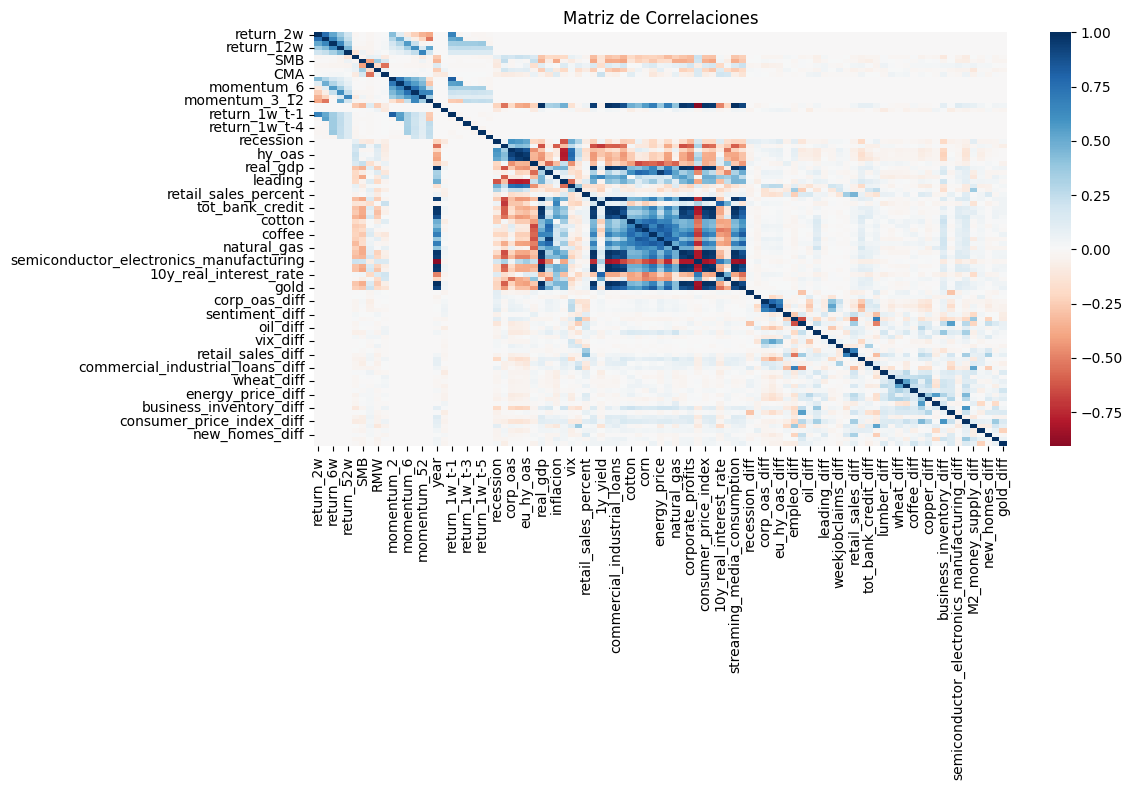


Correlaciones más altas:
streaming_media_consumption  tot_bank_credit         0.994397
                             real_gdp                0.992617
                             consumer_price_index    0.989340
consumer_price_index         business_inventory      0.988265
tot_bank_credit              real_gdp                0.987775
M2_money_supply              tot_bank_credit         0.986798
consumer_price_index         tot_bank_credit         0.985858
streaming_media_consumption  year                    0.985630
business_inventory           real_gdp                0.984942
streaming_media_consumption  business_inventory      0.982655
dtype: float64


In [20]:
# Quitamos la columna sector que no es numérica
columnas_conservar = ['return_1w', 'sector', 'target_1w', ]
data_num = data.drop(columns=columnas_conservar)
data_conservar = data.loc[:, columnas_conservar]

def mostrar_y_eliminar_correlaciones(df, umbral=0.95):
    # Matriz de correlación
    corr_matrix = df.corr().abs()
    
    # Encuentra pares de columnas correlacionadas
    pares_correlacionados = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i,j] > umbral:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                pares_correlacionados.append((col1, col2, corr_matrix.iloc[i,j]))
    
    # Muestra los pares correlacionados
    print("Pares correlacionados:")
    for col1, col2, corr in pares_correlacionados:
        print(f"{col1} - {col2}: {corr:.3f}")
    
    # Decide qué columnas eliminar
    columnas_eliminar = set()
    for col1, col2, _ in pares_correlacionados:
        # Elimina la segunda columna de cada par
        columnas_eliminar.add(col2)
    
    return df.drop(columns=list(columnas_eliminar)), list(columnas_eliminar)

# Uso:
df_limpio, eliminadas = mostrar_y_eliminar_correlaciones(data_num, umbral=0.6)

df_concatenado = pd.concat([data_conservar, df_limpio], axis=1)

df_concatenado.to_hdf(DATA_STORE, 'engineered_features_trimmed')



matriz_correlaciones(data_num)


Pares correlacionados:
return_2w - return_3w: 0.761
return_2w - return_1w_t-1: 0.666
return_3w - return_6w: 0.648
return_6w - return_12w: 0.647
return_12w - momentum_12: 0.613
return_52w - momentum_52: 0.652
momentum_2 - momentum_3: 0.721
momentum_2 - return_1w_t-1: 0.817
momentum_3 - momentum_6: 0.692
momentum_6 - momentum_12: 0.748
momentum_12 - momentum_52: 0.660
momentum_12 - momentum_3_12: 0.643
year - real_gdp: 0.980
year - retail_sales: 0.941
year - tot_bank_credit: 0.980
year - commercial_industrial_loans: 0.957
year - lumber: 0.875
year - coffee: 0.691
year - copper: 0.693
year - business_inventory: 0.966
year - corporate_profits: 0.944
year - semiconductor_electronics_manufacturing: 0.905
year - consumer_price_index: 0.972
year - M2_money_supply: 0.961
year - streaming_media_consumption: 0.986
year - gold: 0.914
recession - leading: 0.627
yield_curve - real_gdp: 0.630
yield_curve - inflacion: 0.601
yield_curve - retail_sales: 0.643
yield_curve - 1y_yield: 0.701
yield_curve - 

In [22]:
df_limpio.shape

(13772, 53)

In [23]:
data_conservar.shape

(13772, 3)

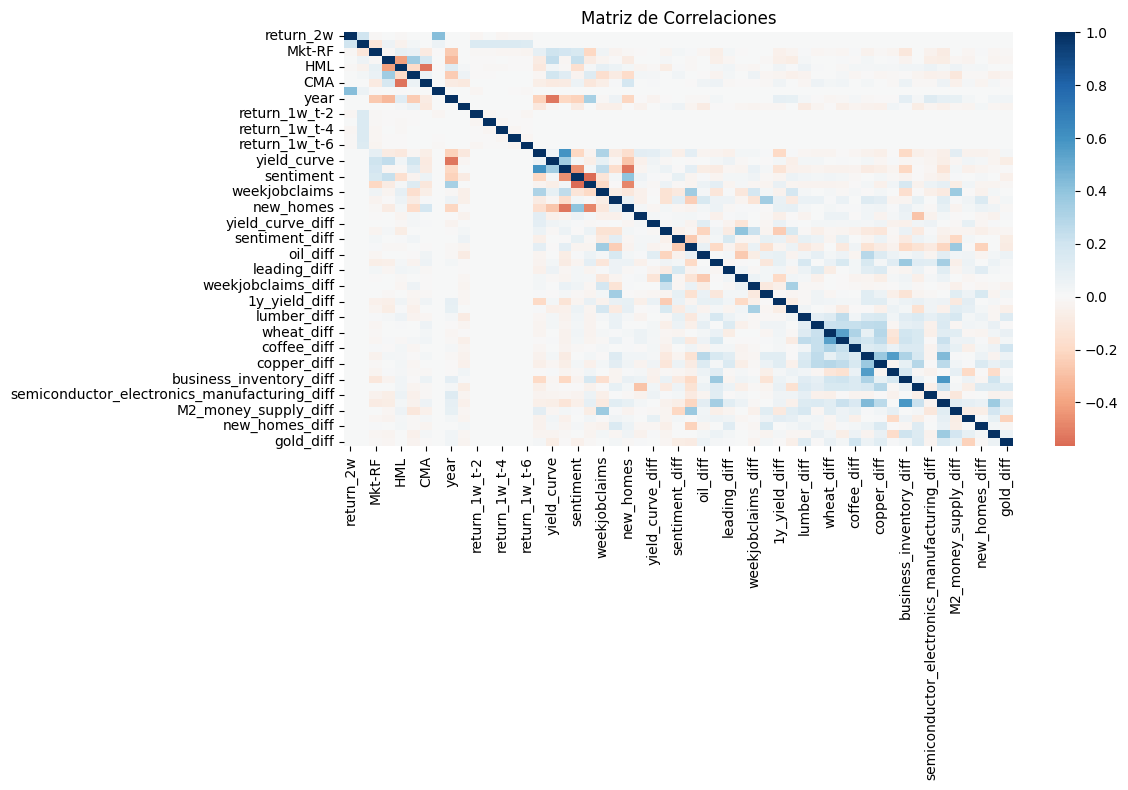


Correlaciones más altas:
corp_oas                   recession                  0.592669
consumer_price_index_diff  business_inventory_diff    0.583519
natural_gas_diff           energy_price_diff          0.558549
corn_diff                  wheat_diff                 0.539718
consumer_price_index_diff  energy_price_diff          0.441843
momentum_2                 return_2w                  0.419942
vix_diff                   corp_oas_diff              0.401085
new_homes                  sentiment                  0.399077
business_inventory_diff    inflacion_diff             0.375420
M2_money_supply_diff       empleo_diff                0.371595
dtype: float64


In [24]:
matriz_correlaciones(df_limpio)

In [25]:
df_limpio.shape

(13772, 53)

/tmp/ipykernel_21721/1825321938.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df_concatenado.to_hdf(DATA_STORE, 'engineered_features_trimmed')


In [27]:
# Imputamos los valores faltantes usando forward fill
df_concatenado_imputado = df_concatenado.fillna(method='ffill')

# Eliminamos las filas que aún tengan valores NaN después de la imputación
df_concatenado_limpio = df_concatenado_imputado.dropna()

print("Dimensiones originales:", df_concatenado.shape)
print("Dimensiones después de imputación y limpieza:", df_concatenado_limpio.shape)

# Actualizamos df_concatenado con los datos limpios
df_concatenado = df_concatenado_limpio


Dimensiones originales: (13772, 56)
Dimensiones después de imputación y limpieza: (13766, 56)


/tmp/ipykernel_21721/1508157407.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_concatenado_imputado = df_concatenado.fillna(method='ffill')


In [28]:
df_concatenado_limpio[df_concatenado_limpio.index.get_level_values('date').year < 2020]

return_1w sector  target_1w  return_2w  return_52w  \
ticker date                                                             
IYR    2001-02-18   0.826154    IYR   0.662044   0.272399    1.257545   
       2001-02-25   0.662044    IYR   0.777357   0.837685    1.140348   
       2001-03-04   0.777357    IYR  -0.233132   0.846311    1.241108   
       2001-03-11  -0.233132    IYR   1.967252   0.410624    1.143394   
       2001-03-18   1.967252    IYR   0.245441   1.227771    1.568912   
...                      ...    ...        ...        ...         ...   
XLY    2019-12-01   0.946143    XLY  -1.025370   0.383575    0.266526   
       2019-12-08  -1.025370    XLY   0.662177   0.125456    0.235897   
       2019-12-15   0.662177    XLY  -0.100234  -0.010810    0.296673   
       2019-12-22  -0.100234    XLY   1.808064   0.544249    0.437624   
       2019-12-29   1.808064    XLY   0.372945   0.678051    0.295391   

                      Mkt-RF        SMB        HML         RMW         CMA  \
ticker date                                                                  
IYR    2001-02-18 -18.186677 -23.632882  18.254006   -0.255327   -9.631714   
       2001-02-25 -18.186677 -23.632882  18.254006   -0.255327   -9.631714   
       2001-03-04 -18.186677 -23.632882  18.254006   -0.255327   -9.631714   
       2001-03-11 -18.186677 -23.632882  18.254006   -0.255327   -9.631714   
       2001-03-18 -18.186677 -23.632882  18.254006   -0.255327   -9.631714   
...                      ...        ...        ...         ...         ...   
XLY    2019-12-01  -8.503558 -84.837328  12.489063  115.274649  -34.838122   
       2019-12-08  16.144844 -55.189270 -18.412114  168.747414  104.824961   
       2019-12-15  16.144844 -55.189270 -18.412114  168.747414  104.824961   
       2019-12-22  16.144844 -55.189270 -18.412114  168.747414  104.824961   
       2019-12-29  16.144844 -55.189270 -18.412114  168.747414  104.824961   

                   ...  natural_gas_diff  business_inventory_diff  \
ticker date        ...                                              
IYR    2001-02-18  ...          0.000000                      0.0   
       2001-02-25  ...          0.000000                      0.0   
       2001-03-04  ...          0.000000                  -5532.0   
       2001-03-11  ...          0.000000                      0.0   
       2001-03-18  ...          0.000000                      0.0   
...                ...               ...                      ...   
XLY    2019-12-01  ...         -0.537471                  -2098.0   
       2019-12-08  ...          0.000000                      0.0   
       2019-12-15  ...          0.000000                      0.0   
       2019-12-22  ...          0.000000                      0.0   
       2019-12-29  ...          0.000000                      0.0   

                   corporate_profits_diff  \
ticker date                                 
IYR    2001-02-18                     0.0   
       2001-02-25                     0.0   
       2001-03-04                     0.0   
       2001-03-11                     0.0   
       2001-03-18                     0.0   
...                                   ...   
XLY    2019-12-01                     0.0   
       2019-12-08                     0.0   
       2019-12-15                     0.0   
       2019-12-22                     0.0   
       2019-12-29                     0.0   

                   semiconductor_electronics_manufacturing_diff  \
ticker date                                                       
IYR    2001-02-18                                           0.0   
       2001-02-25                                           0.0   
       2001-03-04                                          -0.2   
       2001-03-11                                           0.0   
       2001-03-18                                           0.0   
...                                                         ...   
XLY    2019-12-01                 

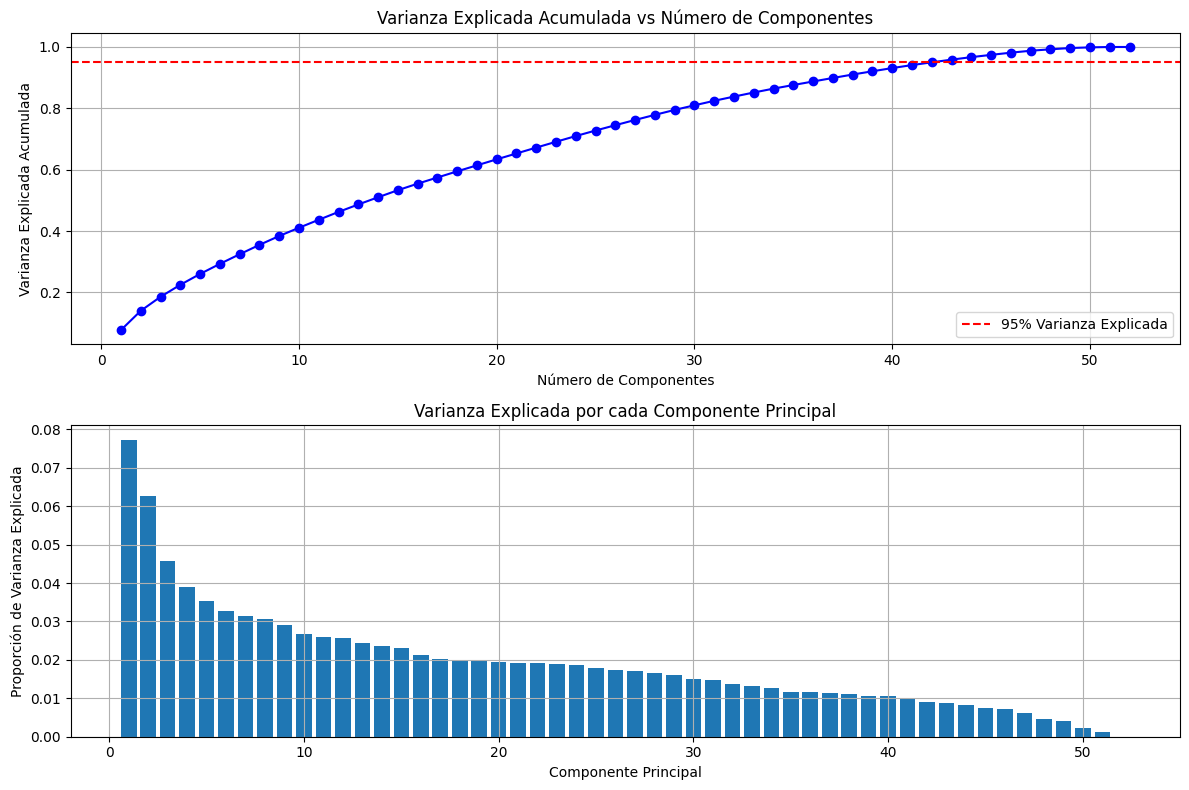


Número de componentes necesarios para explicar el 95% de la varianza: 42


In [29]:
# Separamos los datos antes de 2020 para entrenamiento
datos_pre_2020 = df_concatenado_limpio[df_concatenado_limpio.index.get_level_values('date').year < 2020]
datos_completos = df_concatenado_limpio

# Separamos el target y sector antes
y_train = datos_pre_2020['target_1w']
y_full = datos_completos['target_1w']
sector_train = datos_pre_2020['sector']
sector_full = datos_completos['sector']

# Seleccionamos solo las columnas numéricas
columnas_numericas = datos_pre_2020.select_dtypes(include=['float64', 'int64']).columns
columnas_numericas = columnas_numericas.drop('target_1w')
X_train = datos_pre_2020[columnas_numericas]
X_full = datos_completos[columnas_numericas]

# Estandarizamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_full_scaled = scaler.transform(X_full)

# Entrenamos el PCA
pca = PCA()
pca.fit(X_train_scaled)

# Calculamos la varianza explicada acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Graficamos la varianza explicada acumulada
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada vs Número de Componentes')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varianza Explicada')
plt.legend()

# Graficamos la varianza explicada por cada componente
plt.subplot(2, 1, 2)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Varianza Explicada por cada Componente Principal')
plt.grid(True)
plt.tight_layout()
plt.show()

# Imprimimos el número de componentes necesarios para explicar el 95% de la varianza
n_componentes_95 = np.argmax(varianza_acumulada >= 0.95) + 1
print(f"\nNúmero de componentes necesarios para explicar el 95% de la varianza: {n_componentes_95}")

# Transformamos los datos con PCA
X_train_pca = pca.transform(X_train_scaled)
X_full_pca = pca.transform(X_full_scaled)

# Convertimos a DataFrame y añadimos sector y target
X_train_pca_df = pd.DataFrame(X_train_pca, index=X_train.index, 
                             columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
X_full_pca_df = pd.DataFrame(X_full_pca, index=X_full.index,
                            columns=[f'PC{i+1}' for i in range(X_full_pca.shape[1])])

# Añadimos sector y target
X_train_pca_df['sector'] = sector_train
X_train_pca_df['target_1w'] = y_train
X_full_pca_df['sector'] = sector_full
X_full_pca_df['target_1w'] = y_full



In [30]:
# Guardamos la versión completa
X_full_pca_df.to_hdf(DATA_STORE, 'engineered_features_pca_trimmed')

# Guardamos la versión reducida con 95% de varianza explicada
X_full_pca_df_95 = X_full_pca_df.iloc[:, :n_componentes_95].copy()
X_full_pca_df_95['sector'] = X_full_pca_df['sector'] 
X_full_pca_df_95['target_1w'] = X_full_pca_df['target_1w']
X_full_pca_df_95.to_hdf(DATA_STORE, 'engineered_features_pca_95_trimmed')


/tmp/ipykernel_21721/2684054858.py:2: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  X_full_pca_df.to_hdf(DATA_STORE, 'engineered_features_pca_trimmed')
/tmp/ipykernel_21721/2684054858.py:8: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  X_full_pca_df_95.to_hdf(DATA_STORE, 'engineered_features_pca_95_trimmed')


In [31]:
# Guardamos la versión con 10 componentes principales
X_full_pca_df_10 = X_full_pca_df.iloc[:, :10].copy()
X_full_pca_df_10['sector'] = X_full_pca_df['sector']
X_full_pca_df_10['target_1w'] = X_full_pca_df['target_1w']
X_full_pca_df_10.to_hdf(DATA_STORE, 'engineered_features_pca_10_trimmed')


/tmp/ipykernel_21721/568995915.py:5: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  X_full_pca_df_10.to_hdf(DATA_STORE, 'engineered_features_pca_10_trimmed')


In [32]:
import pandas as pd
df = pd.read_hdf(DATA_STORE, 'engineered_features_pca_trimmed')
df.head()

PC1       PC2       PC3       PC4       PC5       PC6  \
ticker date                                                                     
IYR    2001-02-18 -0.086386 -0.688610 -0.733549 -1.495204  0.206800  1.132035   
       2001-02-25  0.569711 -1.034820  0.344827 -2.374965  0.131509  1.323533   
       2001-03-04  1.013512 -1.804047  1.075301 -2.532313 -1.158105  2.872137   
       2001-03-11  0.304584 -0.540640 -0.692659 -1.797569 -0.077043  0.850683   
       2001-03-18  0.704920 -1.029505  0.526186 -2.644085  0.839642  2.367363   

                        PC7       PC8       PC9      PC10  ...      PC45  \
ticker date                                                ...             
IYR    2001-02-18 -0.294432 -0.488419 -1.191404 -0.463787  ... -0.117814   
       2001-02-25  0.971176 -1.427811 -0.800676 -0.444513  ...  0.284594   
       2001-03-04 -0.152578  0.192299 -0.545640  0.812632  ... -0.808175   
       2001-03-11 -0.858264 -0.692886 -1.118421  0.782199  ...  0.109209   
       2001-03-18  1.816074 -1.223654 -0.812550 -0.858932  ...  0.456021   

                       PC46      PC47      PC48      PC49      PC50      PC51  \
ticker date                                                                     
IYR    2001-02-18 -0.326009  0.450924  0.477177  0.258576 -0.816502 -0.183310   
       2001-02-25  0.007004  0.586113  0.312960  0.301077 -0.617549 -0.152157   
       2001-03-04  0.372735 -0.395313  0.658585  0.133137 -0.867749 -0.086393   
       2001-03-11 -0.137011  0.255377  0.479269  0.231613 -0.947238 -0.039335   
       2001-03-18  0.129723  0.314251  0.370430  0.373372 -0.813461 -0.036510   

                           PC52  sector  target_1w  
ticker date                                         
IYR    2001-02-18  2.794455e-16     IYR   0.662044  
       2001-02-25  5.898541e-16     IYR   0.777357  
       2001-03-04  8.424030e-16     IYR  -0.233132  
       2001-03-11  9.429299e-16     IYR   1.967252  
       2001-03-18 -9.236574e-17     IYR   0.245441  

[5 rows x 54 columns]

In [33]:

X_full_pca_df_95

PC1       PC2       PC3       PC4       PC5       PC6  \
ticker date                                                                     
IYR    2001-02-18 -0.086386 -0.688610 -0.733549 -1.495204  0.206800  1.132035   
       2001-02-25  0.569711 -1.034820  0.344827 -2.374965  0.131509  1.323533   
       2001-03-04  1.013512 -1.804047  1.075301 -2.532313 -1.158105  2.872137   
       2001-03-11  0.304584 -0.540640 -0.692659 -1.797569 -0.077043  0.850683   
       2001-03-18  0.704920 -1.029505  0.526186 -2.644085  0.839642  2.367363   
...                     ...       ...       ...       ...       ...       ...   
XLY    2024-12-01 -0.587353 -1.352322  0.570069 -0.671770  1.162493  0.347079   
       2024-12-08 -0.627408 -0.627059  0.053569 -0.533927  2.243875  1.653494   
       2024-12-15 -1.061440 -0.444587 -0.428470 -0.021891  2.624572  1.821463   
       2024-12-22 -0.747930 -0.787067  0.307076 -0.179046  1.681029  0.445072   
       2024-12-29 -0.808448 -0.571050 -0.132642 -0.074657  2.074952  1.180072   

                        PC7       PC8       PC9      PC10  ...      PC35  \
ticker date                                                ...             
IYR    2001-02-18 -0.294432 -0.488419 -1.191404 -0.463787  ...  0.907857   
       2001-02-25  0.971176 -1.427811 -0.800676 -0.444513  ...  0.306262   
       2001-03-04 -0.152578  0.192299 -0.545640  0.812632  ... -0.167846   
       2001-03-11 -0.858264 -0.692886 -1.118421  0.782199  ...  0.028317   
       2001-03-18  1.816074 -1.223654 -0.812550 -0.858932  ... -0.506650   
...                     ...       ...       ...       ...  ...       ...   
XLY    2024-12-01  0.673163  0.239965  0.805522 -0.935160  ... -1.596177   
       2024-12-08 -0.336350  0.275878 -0.036364 -1.285168  ... -1.363729   
       2024-12-15 -1.001413  0.113754 -0.308416 -1.505772  ... -0.225607   
       2024-12-22  0.450752  0.115737  0.426723 -0.204358  ... -0.440103   
       2024-12-29 -0.275251  0.468403  0.095668 -1.306101  ... -0.976638   

                       PC36      PC37      PC38      PC39      PC40      PC41  \
ticker date                                                                     
IYR    2001-02-18 -0.079095 -0.676963  1.113846 -0.529181 -0.331660  0.598050   
       2001-02-25 -0.045183  0.073038  0.026040 -0.149034 -0.467671  1.120976   
       2001-03-04  0.343746 -0.465326  1.332078  0.069425 -0.631995  0.278340   
       2001-03-11 -0.187671  0.073600  0.296639 -0.213464 -0.458548  0.668340   
       2001-03-18 -0.012324  0.239170 -0.185530 -0.140436 -0.297765  1.157552   
...                     ...       ...       ...       ...       ...       ...   
XLY    2024-12-01 -0.287898  0.419559 -0.233904 -0.817752  0.129944  0.846551   
       2024-12-08 -0.652678  0.292233 -0.315770 -0.345292 -0.630252  0.889794   
       2024-12-15 -1.030374 -0.344211  0.810737 -0.099541 -0.208405  0.948207   
       2024-12-22 -1.135013 -0.453942  0.688701 -0.060358 -0.354185  0.580110   
       2024-12-29 -0.646083 -0.062482  0.197735 -0.486244 -0.329354  0.439929   

                       PC42  sector  target_1w  
ticker date                                     
IYR    2001-02-18  0.157642     IYR   0.662044  
       2001-02-25  0.346744     IYR   0.777357  
       2001-03-04  0.154348     IYR  -0.233132  
       2001-03-11  0.133999     IYR   1.967252  
       2001-03-18  0.410873     IYR   0.245441  
...                     ...     ...        ...  
XLY    2024-12-01 -0.921869     XLY   1.759309  
       2024-12-08 -0.335022     XLY   2.023119  
       2024-12-15  0.459667     XLY   0.160246  
       2024-12-22  0.230932     XLY   1.652266  
       2024-12-29 -0.445957     XLY   1.652266  

[13766 rows x 44 columns]

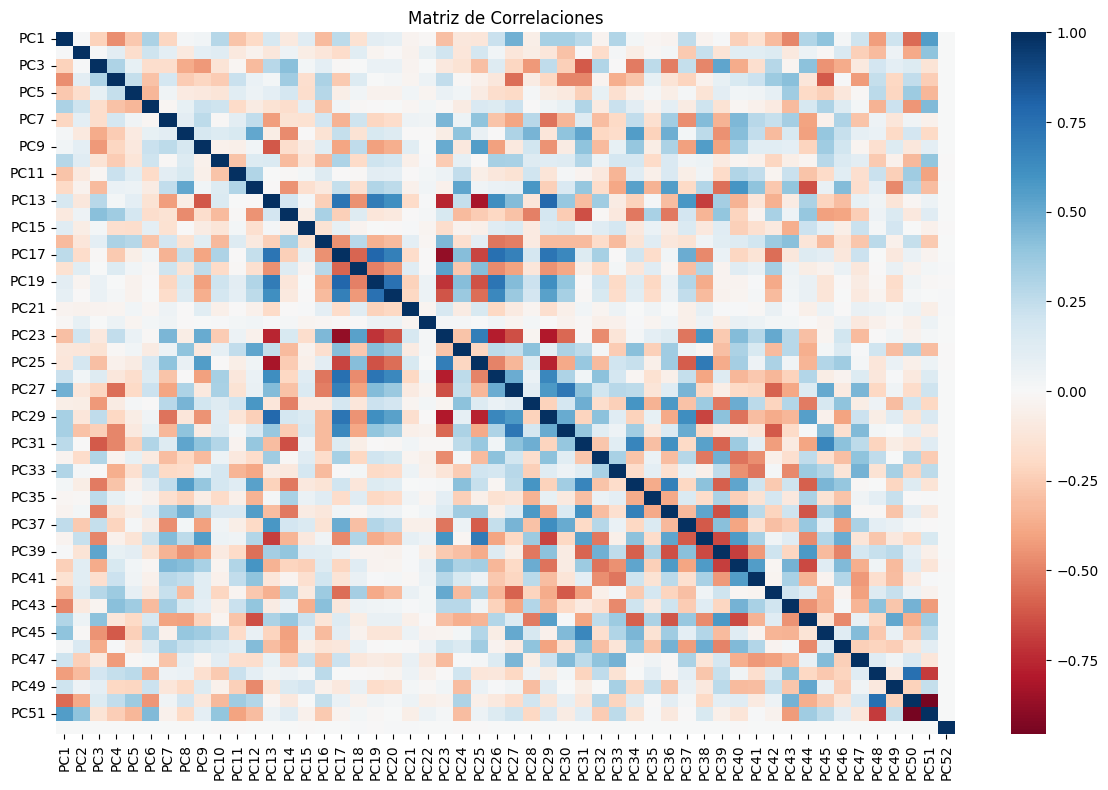


Correlaciones más altas:
PC19  PC17    0.786195
PC29  PC13    0.783423
PC26  PC17    0.755205
PC50  PC48    0.752784
PC20  PC19    0.742033
PC26  PC19    0.728411
PC29  PC17    0.726446
PC17  PC13    0.724887
PC30  PC27    0.718266
PC38  PC25    0.708047
dtype: float64


In [34]:
matriz_correlaciones(X_full_pca_df.drop(columns=['sector', 'target_1w']))
